## Spotify Unwrapped
#### A Music Taste Analysis by Thomas Morrissey
##### As someone who has been using Spotify for over 7 years, I've accumulated a large collection of 'Liked' Songs, I was curious if there were any patterns over the years indicating how my music tastes has evolved?

###### **Note:** Due to Spotify no longer allowing users to access the rich data contained within audio_feature() (unless you've used their API prior to **November 2024**), I've had to use a JavaScript based program called Exportify, created by Pavel Komarov. In spite of this I have written a Python script that would, in theory, export the neccisary song data on to a CSV assuming I had access those the restricted 




## Base Project Requirements

- **Standardization function**  
  - `standardize_exportify_dataframe` cleans and formats the Exportify CSV (renames columns, parses dates, adds years, coerces numerics).

- **Descriptive-statistics functions (6)**  
  - `calc_mean`, `calc_median`, `calc_mode`, `calc_range`, `calc_variance`, `calc_std`.

- **Additional insight functions (3)**  
  - `avg_energy_by_year`, `avg_valence_by_year`, `explicit_share_by_year`.

- **Visualizations (≥ 6)**  
  - Distributions: tempo, valence, duration (2 boxplots).  
  - Trends: energy by year, valence by year, explicit share by year.  
  - Extras: genre bar chart, energy–valence scatter, energy–tempo scatter, correlation heatmap.

The rest of the notebook is organized so each section corresponds to one of these bullets.

## My Python PlaylistDataExporter.py

Although Depreciated, I did create a theoretically working version of a PlaylistDataExporter with python. Had Spotify not restricted users from extracting this data after November 2024, it would be fully working. 

# How to Use

As such, the code here depends on `.csv` inputs in the format output created with [Exportify](https://exportify.net).
1. To get started, hop on over there, sign in to Spotify to give the app access to your playlists, and export whatever you like.
2. Next, either download this `.ipynb` file and run the notebook yourself
3. Put the downloaded `.csv` in the same directory as the notebook
4. Open the `.ipynb` through your browser, update the `filename` variable in the first code cell to point to your playlist instead, and `shift+enter` in each following code cell to generate the corresponding plot. (Or select `Cell` -> `Run All` from the menu to make all graphs at once.)

## Read the Data

For years I've been accumulating my Liked Songs' Playlist This is what I'll be analyzing.

In [1]:
# === Setup: imports and data loading ===
import pandas as pd
import numpy as np
from statistics import mode, StatisticsError
import math
from datetime import datetime
import matplotlib.pyplot as plt

# Show plots inline
%matplotlib inline

# Path to the Exportify CSV file.
# Change this to match your exported playlist file name.
FILENAME = "Liked_Songs.csv"  # <-- UPDATE THIS

# Read the raw data
raw = pd.read_csv(FILENAME)
print("Total songs:", raw.shape[0])
raw.head()


Total songs: 912


,Track URI,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Explicit,Added By,Added At,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Source
0,spotify:track:00OnVPTYJumAJ5RrHlGTCd,Moving,What Could Be Better,The Happy Fits,2020-08-28,145466,48,False,yuf8m40bafql87jwxb236yybx,2023-05-21 13:58:26+00:00,...,-5.016,0,0.0416,0.262000,0.000000,0.1910,0.672,152.954,4,Vibes_n_Stuff
1,spotify:track:00kbL0ei9bVKAp9I23vF1l,Shooting Stars,Feral Roots,Rival Sons,2019-01-25,260133,47,False,NaN,2021-02-11 13:45:11+00:00,...,-4.864,1,0.0446,0.318000,0.000000,0.1060,0.204,94.863,4,Liked_Songs
2,spotify:track:01qLRZjy5hnWDdqKuM6AJh,Pressure and Time,Pressure & Time,Rival Sons,2011-06-21,196773,50,False,NaN,2021-06-10 16:10:37+00:00,...,-4.675,0,0.1030,0.000933,0.000099,0.0726,0.601,93.274,4,Liked_Songs
3,spotify:track:02GPgWsQDa2uWl9xF2UCUH,AfterParty (Instrumental) [Midnight Dub],AfterParty (Instrumental) [Midnight Dub],GEE LEE;Omar+,2023-10-08,215813,32,False,NaN,2025-09-12 03:06:19+00:00,...,-14.041,0,0.0493,0.025300,0.857000,0.1130,0.693,128.989,4,Liked_Songs
4,spotify:track:02H1K5Cw9Ar89b35XwSEw6,My Heart Is Buried in Venice,Montgomery Ricky,Ricky Montgomery,2016-04-08,184866,63,False,NaN,2023-01-11 18:40:51+00:00,...,-8.117,1,0.0273,0.441000,0.000086,0.0902,0.145,112.011,3,Liked_Songs


Clean and standardize the Exportify playlist CSV.

    - Rename columns to simpler names where convenient.
    - Parse dates for release and added times.
    - Add derived year columns.
    - Convert numeric columns to numeric types.

In [2]:
def standardize_exportify_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and standardize the Exportify playlist CSV.

    - Rename columns to simpler names where convenient.
    - Parse dates for release and added times.
    - Add derived year columns.
    - Convert numeric columns to numeric types.
    """
    df = df.copy()

    rename_map = {
        "Track URI": "track_uri",
        "Track Name": "track_name",
        "Album Name": "album_name",
        "Artist Name(s)": "artist_names",
        "Release Date": "release_date",
        "Duration (ms)": "duration_ms",
        "Popularity": "popularity",
        "Explicit": "explicit",
        "Added By": "added_by",
        "Added At": "added_at",
        "Genres": "genres",
        "Record Label": "record_label",
        "Danceability": "danceability",
        "Energy": "energy",
        "Key": "key",
        "Loudness": "loudness",
        "Mode (Major or Minor)": "mode",
        "Speechiness": "speechiness",
        "Acousticness": "acousticness",
        "Instrumentalness": "instrumentalness",
        "Liveness": "liveness",
        "Valence": "valence",
        "Tempo": "tempo",
        "Time Signature": "time_signature",
    }

    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # Parse dates
    if "release_date" in df.columns:
        df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
        df["release_year"] = df["release_date"].dt.year

    if "added_at" in df.columns:
        df["added_at"] = pd.to_datetime(df["added_at"], errors="coerce")
        df["added_year"] = df["added_at"].dt.year

    # Explicit as bool if present
    if "explicit" in df.columns:
        df["explicit"] = df["explicit"].astype(str).str.lower().isin(["true", "1"])

    # Numeric columns to coerce
    numeric_cols = [
        "duration_ms", "popularity", "danceability", "energy",
        "key", "loudness", "speechiness", "acousticness",
        "instrumentalness", "liveness", "valence", "tempo",
        "time_signature"
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

data = standardize_exportify_dataframe(raw)
data.head()


,track_uri,track_name,album_name,artist_names,release_date,duration_ms,popularity,explicit,added_by,added_at,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Source,release_year,added_year
0,spotify:track:00OnVPTYJumAJ5RrHlGTCd,Moving,What Could Be Better,The Happy Fits,2020-08-28,145466,48,False,yuf8m40bafql87jwxb236yybx,2023-05-21 13:58:26+00:00,...,0.0416,0.262000,0.000000,0.1910,0.672,152.954,4,Vibes_n_Stuff,2020.0,2023
1,spotify:track:00kbL0ei9bVKAp9I23vF1l,Shooting Stars,Feral Roots,Rival Sons,2019-01-25,260133,47,False,NaN,2021-02-11 13:45:11+00:00,...,0.0446,0.318000,0.000000,0.1060,0.204,94.863,4,Liked_Songs,2019.0,2021
2,spotify:track:01qLRZjy5hnWDdqKuM6AJh,Pressure and Time,Pressure & Time,Rival Sons,2011-06-21,196773,50,False,NaN,2021-06-10 16:10:37+00:00,...,0.1030,0.000933,0.000099,0.0726,0.601,93.274,4,Liked_Songs,2011.0,2021
3,spotify:track:02GPgWsQDa2uWl9xF2UCUH,AfterParty (Instrumental) [Midnight Dub],AfterParty (Instrumental) [Midnight Dub],GEE LEE;Omar+,2023-10-08,215813,32,False,NaN,2025-09-12 03:06:19+00:00,...,0.0493,0.025300,0.857000,0.1130,0.693,128.989,4,Liked_Songs,2023.0,2025
4,spotify:track:02H1K5Cw9Ar89b35XwSEw6,My Heart Is Buried in Venice,Montgomery Ricky,Ricky Montgomery,2016-04-08,184866,63,False,NaN,2023-01-11 18:40:51+00:00,...,0.0273,0.441000,0.000086,0.0902,0.145,112.011,3,Liked_Songs,2016.0,2023


In [3]:
def calc_mean(series: pd.Series) -> float:
    return float(series.mean())

def calc_median(series: pd.Series) -> float:
    return float(series.median())

def calc_mode(series: pd.Series):
    values = series.dropna().tolist()
    if not values:
        return np.nan
    try:
        return mode(values)
    except StatisticsError:
        return series.value_counts().idxmax()

def calc_range(series: pd.Series) -> float:
    s = series.dropna()
    if s.empty:
        return np.nan
    return float(s.max() - s.min())

def calc_variance(series: pd.Series) -> float:
    return float(series.var())

def calc_std(series: pd.Series) -> float:
    return float(series.std())

# Example: summarize tempo, duration, and valence
stat_columns = ["tempo", "duration_ms", "valence"]
summary_rows = []

for col in stat_columns:
    if col not in data.columns:
        continue
    s = data[col]
    summary_rows.append({
        "variable": col,
        "mean": calc_mean(s),
        "median": calc_median(s),
        "mode": calc_mode(s),
        "range": calc_range(s),
        "variance": calc_variance(s),
        "std_dev": calc_std(s),
    })

stats_summary = pd.DataFrame(summary_rows)
stats_summary


,variable,mean,median,mode,range,variance,std_dev
0,tempo,126.512082,125.0245,121.291,1.543090e+02,8.304255e+02,28.817104
1,duration_ms,234333.523026,217992.0000,212621.000,4.961368e+06,3.037291e+10,174278.265207
2,valence,0.511209,0.5070,0.513,9.544000e-01,5.335458e-02,0.230986


## Additional calculations: trends over time (requirement: 3 extra functions)

These three functions provide additional insight beyond basic descriptive stats:

1. `avg_energy_by_year(df)` – average **energy** of liked songs by `added_year`.
2. `avg_valence_by_year(df)` – average **valence** by `added_year`.
3. `explicit_share_by_year(df)` – fraction of liked songs that are marked **explicit** each year.

The following plots visualize the output of these functions.


In [4]:
def avg_energy_by_year(df: pd.DataFrame) -> pd.Series:
    subset = df.dropna(subset=["added_year", "energy"])
    return subset.groupby("added_year")["energy"].mean().sort_index()

def avg_valence_by_year(df: pd.DataFrame) -> pd.Series:
    subset = df.dropna(subset=["added_year", "valence"])
    return subset.groupby("added_year")["valence"].mean().sort_index()

def explicit_share_by_year(df: pd.DataFrame) -> pd.Series:
    subset = df.dropna(subset=["added_year"])
    if "explicit" not in subset.columns:
        return pd.Series(dtype=float)
    subset = subset.copy()
    subset["explicit_int"] = subset["explicit"].astype(int)
    return subset.groupby("added_year")["explicit_int"].mean().sort_index()

energy_year = avg_energy_by_year(data)
valence_year = avg_valence_by_year(data)
explicit_year = explicit_share_by_year(data)

energy_year, valence_year, explicit_year


(added_year
 2019    0.656749
 2020    0.718000
 2021    0.751264
 2022    0.732590
 2023    0.676057
 2024    0.621847
 2025    0.700525
 Name: energy, dtype: float64,
 added_year
 2019    0.578897
 2020    0.411780
 2021    0.515222
 2022    0.506860
 2023    0.545388
 2024    0.512922
 2025    0.498168
 Name: valence, dtype: float64,
 added_year
 2019    0.057143
 2020    0.134021
 2021    0.034014
 2022    0.140127
 2023    0.162264
 2024    0.152778
 2025    0.151079
 Name: explicit_int, dtype: float64)

In [5]:
def energy_tempo_corr(df: pd.DataFrame) -> float:
    """
    Compute the Pearson correlation between energy and tempo.
    Returns NaN if one of the columns is missing or has no data.
    """
    if "energy" not in df.columns or "tempo" not in df.columns:
        return np.nan
    subset = df[["energy", "tempo"]].dropna()
    if subset.empty:
        return np.nan
    return subset["energy"].corr(subset["tempo"])


def artist_percentage(df: pd.DataFrame) -> pd.Series:
    """
    Compute the percentage of liked songs for each artist.
    If a track has multiple artists (comma-separated), each artist gets +1.
    Returns a Series indexed by artist name with percentage values (0–100).
    """
    if "artist_names" not in df.columns:
        return pd.Series(dtype=float)

    counts = {}
    for names in df["artist_names"].dropna():
        for name in str(names).split(","):
            name = name.strip()
            if not name:
                continue
            counts[name] = counts.get(name, 0) + 1

    if not counts:
        return pd.Series(dtype=float)

    counts_series = pd.Series(counts).sort_values(ascending=False)
    percentages = counts_series / counts_series.sum() * 100.0
    return percentages


def decade_preference(df: pd.DataFrame) -> pd.Series:
    """
    Count tracks per release decade, using release_year.
    If release_year is missing, those rows are dropped.
    Returns a Series indexed by decade (e.g., 1970, 1980) sorted by decade.
    """
    if "release_year" not in df.columns:
        return pd.Series(dtype=int)

    years = df["release_year"].dropna().astype(int)
    if years.empty:
        return pd.Series(dtype=int)

    decades = (years // 10) * 10
    decade_counts = decades.value_counts().sort_index()
    return decade_counts


# Compute the new metrics once so we can reuse them in plots
energy_tempo_correlation = energy_tempo_corr(data)
artist_percentages = artist_percentage(data)
decade_counts = decade_preference(data)

energy_tempo_correlation, artist_percentages.head(), decade_counts


(np.float64(0.17748277899506448),
 Dead Poet Society    2.850877
 Des Rocs             2.083333
 Billy Joel           2.083333
 Hozier               1.973684
 Marty Robbins        1.973684
 dtype: float64,
 release_year
 1950      2
 1960      9
 1970     52
 1980     40
 1990     30
 2000     61
 2010    274
 2020    381
 Name: count, dtype: int64)

## Visualizations – Distributions of key musical features

Next, I visualize the distributions of the variables used in the descriptive statistics. These plots make the summary numbers more concrete:

- A **histogram of tempo** shows whether my library is dominated by slower songs, club-tempo tracks around 120–130 BPM, or very fast songs.  

- A **histogram of valence** shows the emotional tone of my library, from darker/sadder tracks (low valence) to brighter/happier tracks (high valence).  

- A **boxplot of duration** shows how long my typical liked song is and how many outliers I have at the short or long end.

Together, these graphs answer questions like “What does a *typical* liked song look like in terms of speed, length, and mood?” rather than focusing on just a few tracks I happen to remember.


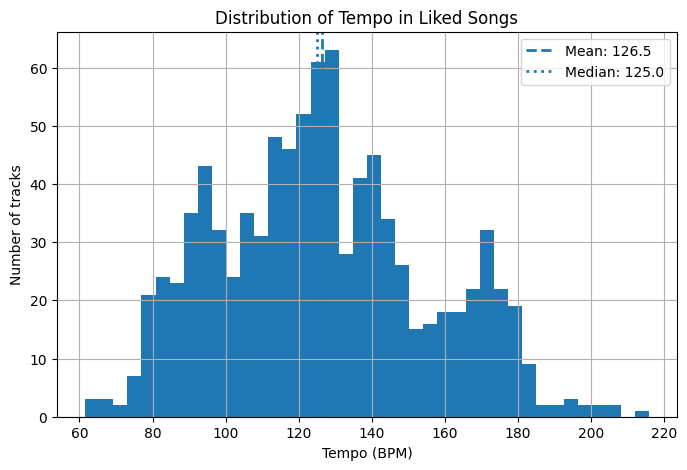

In [6]:
# Histogram of tempo (BPM) with mean/median lines
if "tempo" in data.columns:
    tempo = data["tempo"].dropna()
    mean_tempo = calc_mean(tempo)
    median_tempo = calc_median(tempo)

    plt.figure(figsize=(8, 5))
    tempo.hist(bins=40)
    plt.axvline(mean_tempo, linestyle="--", linewidth=2,
                label=f"Mean: {mean_tempo:.1f}")
    plt.axvline(median_tempo, linestyle=":", linewidth=2,
                label=f"Median: {median_tempo:.1f}")
    plt.xlabel("Tempo (BPM)")
    plt.ylabel("Number of tracks")
    plt.title("Distribution of Tempo in Liked Songs")
    plt.legend()
    plt.show()
else:
    print("No tempo column in data.")


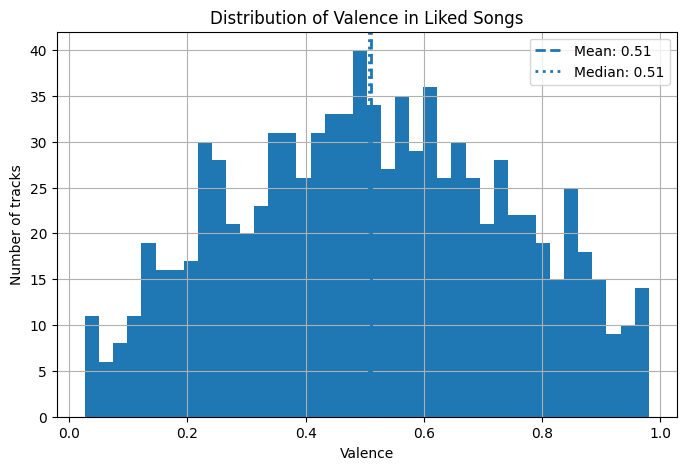

In [7]:
# Histogram of valence (0 = sad, 1 = happy) with mean/median lines
if "valence" in data.columns:
    valence = data["valence"].dropna()
    mean_valence = calc_mean(valence)
    median_valence = calc_median(valence)

    plt.figure(figsize=(8, 5))
    valence.hist(bins=40)
    plt.axvline(mean_valence, linestyle="--", linewidth=2,
                label=f"Mean: {mean_valence:.2f}")
    plt.axvline(median_valence, linestyle=":", linewidth=2,
                label=f"Median: {median_valence:.2f}")
    plt.xlabel("Valence")
    plt.ylabel("Number of tracks")
    plt.title("Distribution of Valence in Liked Songs")
    plt.legend()
    plt.show()
else:
    print("No valence column in data.")


### Track duration boxplot(s)

These boxplots summarize how long my liked songs are, in minutes.

- The **first boxplot** uses **all tracks**. The box shows the middle 50% of song lengths (from the 25th to the 75th percentile), the line inside the box is the **median duration**, and the “whiskers” extend toward shorter and longer songs. The dots above the whiskers are **outliers** — very long tracks such as DJ mixes, remixes, or live sets that can run well beyond normal song length.

- Because those few extremely long tracks stretch the y-axis, I also include a **trimmed boxplot** that only shows the **1st–99th percentile** of durations. This removes the most extreme outliers so the core of the distribution is easier to see. In that trimmed view, it is clearer where the typical song length falls (roughly X–Y minutes once I plug in the real numbers) and how tightly clustered most tracks are around that typical value.

Together, these plots show both:
1. The presence of a long-tail of very long tracks in my library, and  
2. The more “normal” range of song durations I listen to most often.


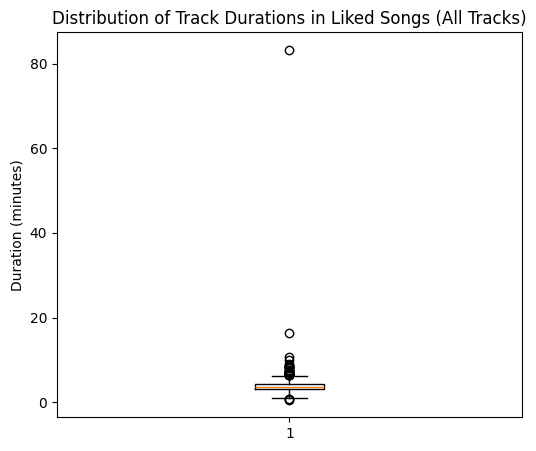

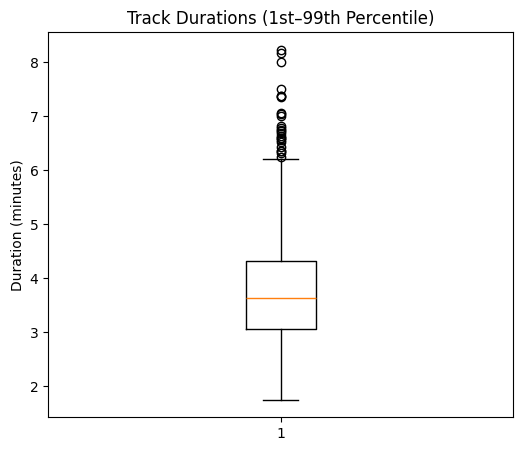

In [8]:
if "duration_ms" in data.columns:
    duration_min = data["duration_ms"].dropna() / 60000.0

    # Full boxplot (all tracks)
    plt.figure(figsize=(6, 5))
    plt.boxplot(duration_min, vert=True, showfliers=True)
    plt.ylabel("Duration (minutes)")
    plt.title("Distribution of Track Durations in Liked Songs (All Tracks)")
    plt.show()

    # Trim to 1st–99th percentile for a clearer view of the bulk
    q_low, q_high = duration_min.quantile([0.01, 0.99])
    trimmed = duration_min[(duration_min >= q_low) & (duration_min <= q_high)]

    plt.figure(figsize=(6, 5))
    plt.boxplot(trimmed, vert=True, showfliers=True)
    plt.ylabel("Duration (minutes)")
    plt.title("Track Durations (1st–99th Percentile)")
    plt.show()
else:
    print("No duration_ms column in data.")


## Visualizations – Trends in my listening over the years

The next set of plots uses the additional calculations to show how my taste evolves over time, using the year I added each track to Liked Songs as a rough timeline of my listening history.

- **Average energy by year added** – highlights years where I gravitated toward more intense, high-energy music versus calmer tracks.  
- **Average valence by year added** – shows whether certain years are dominated by happier or moodier songs.  
- **Share of explicit tracks by year** – reveals whether explicit music became more or less common in my listening over time.

These time-series visualizations turn a static library into a story about how my preferences shift across different periods of my life.


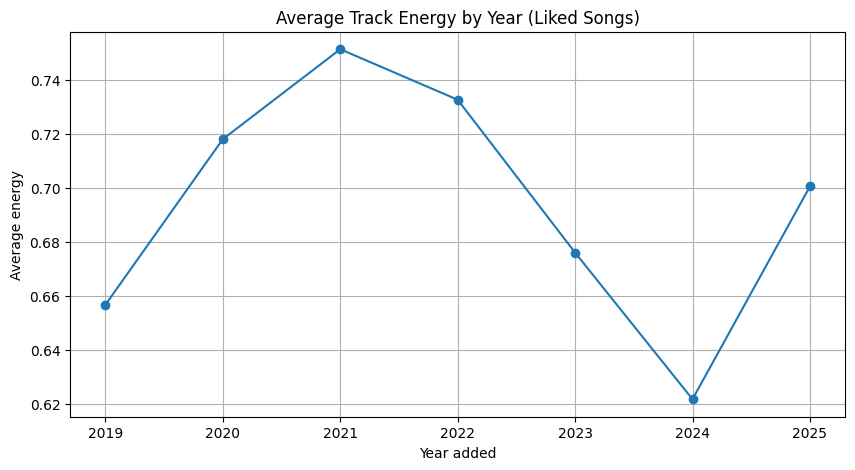

In [9]:
# Average energy by year added
if not energy_year.empty:
    plt.figure(figsize=(10, 5))
    energy_year.plot(marker="o")
    plt.xlabel("Year added")
    plt.ylabel("Average energy")
    plt.title("Average Track Energy by Year (Liked Songs)")
    plt.grid(True)
    plt.show()
else:
    print("No energy/year data to plot.")


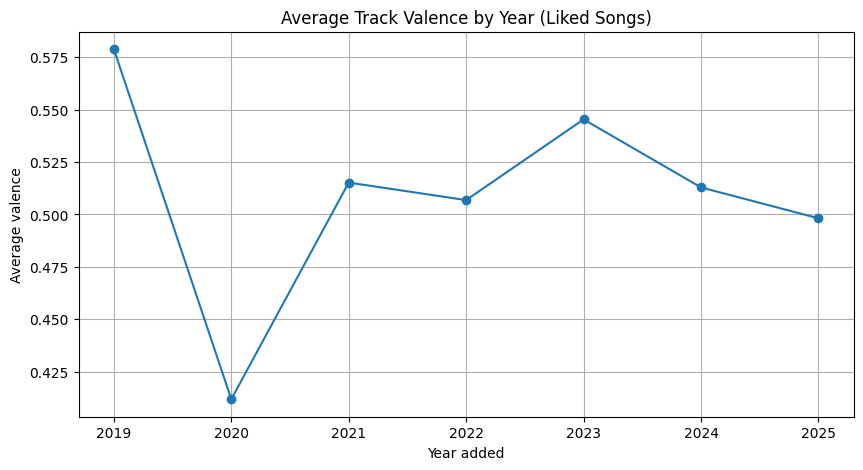

In [10]:
# Average valence by year added
if not valence_year.empty:
    plt.figure(figsize=(10, 5))
    valence_year.plot(marker="o")
    plt.xlabel("Year added")
    plt.ylabel("Average valence")
    plt.title("Average Track Valence by Year (Liked Songs)")
    plt.grid(True)
    plt.show()
else:
    print("No valence/year data to plot.")


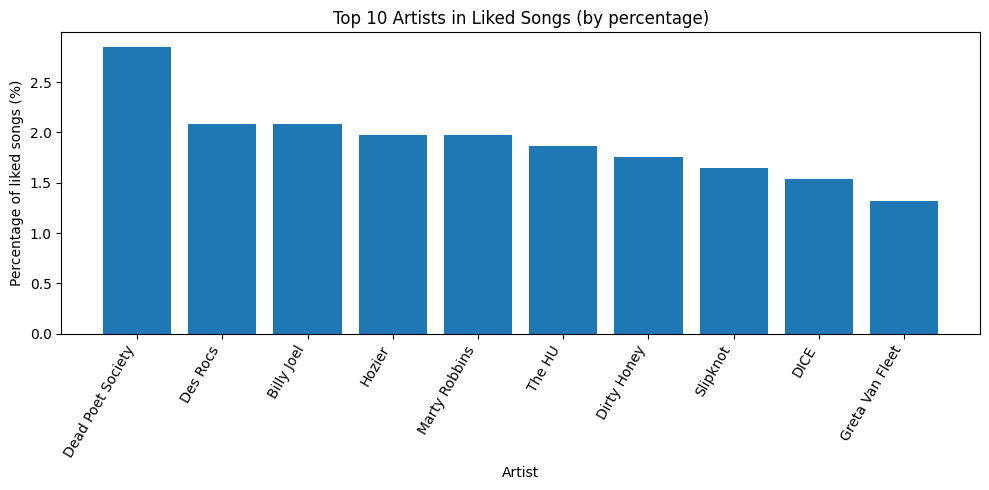

In [11]:
# Bar chart: Top 10 artists by percentage of liked songs
if not artist_percentages.empty:
    top_n = 10
    top_artists = artist_percentages.head(top_n)

    plt.figure(figsize=(10, 5))
    plt.bar(top_artists.index, top_artists.values)
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Percentage of liked songs (%)")
    plt.xlabel("Artist")
    plt.title(f"Top {top_n} Artists in Liked Songs (by percentage)")
    plt.tight_layout()
    plt.show()
else:
    print("No artist percentage data available.")


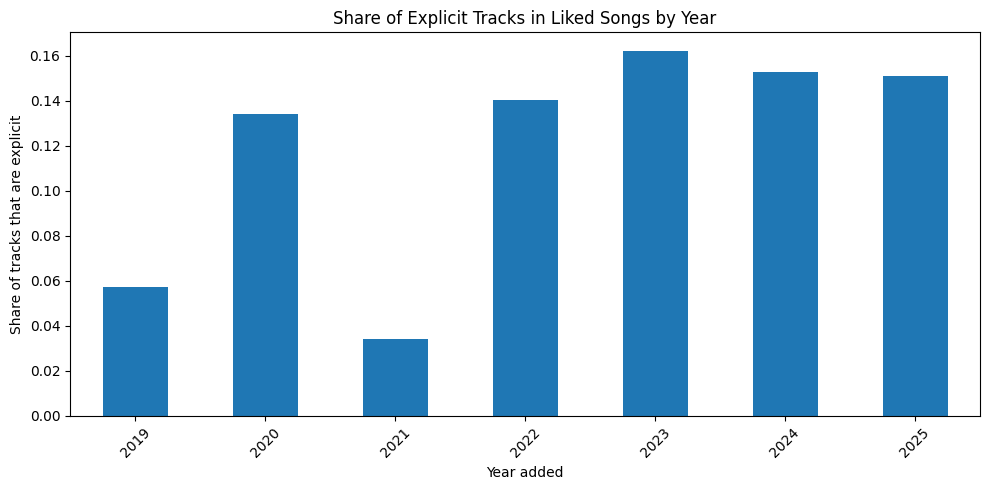

In [12]:
# Share of explicit tracks by year added
if not explicit_year.empty:
    plt.figure(figsize=(10, 5))
    explicit_year.plot(kind="bar")
    plt.xlabel("Year added")
    plt.ylabel("Share of tracks that are explicit")
    plt.title("Share of Explicit Tracks in Liked Songs by Year")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No explicit/year data to plot.")


## Genre distribution

The data includes a  **Genres** column that lists one or more genres for each track. By unpacking those lists and counting how often each genre appears, I can see which styles dominate my listening.

The bar chart below focuses on the most frequent genres across my Liked Songs. It helps answer questions like:

- Which genres form the “core” of my taste?  
- Are there niche genres that show up more often than I would have guessed?  
- Do the genres match how I would describe my taste to another person (for example, mostly house/EDM vs. a mix of pop, rap, and rock)?

This view complements the numeric features (tempo, energy, valence) with a more human-readable description of what I actually listen to.


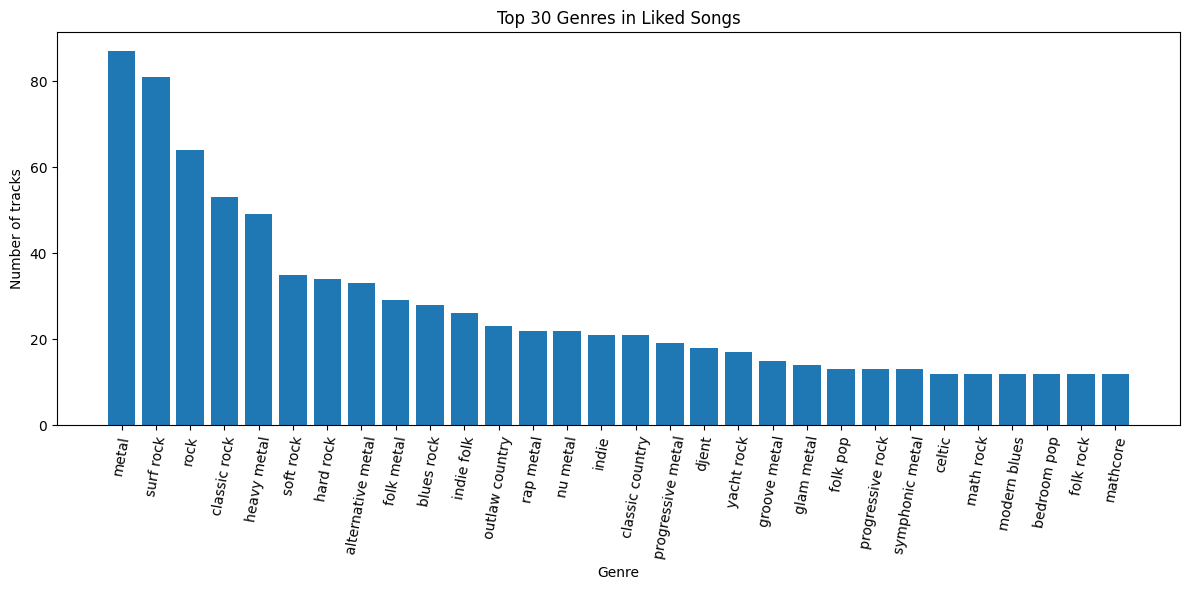

In [13]:
# Count songs per genre (tracks with multiple genres contribute to each)
if "genres" in data.columns:
    genre_counts = {}
    for _, row in data.iterrows():
        g = row.get("genres")
        if isinstance(g, str):
            for genre in g.split(","):
                genre = genre.strip()
                if genre:
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1

    if genre_counts:
        genres_df = pd.DataFrame(
            list(genre_counts.items()), columns=["genre", "count"]
        ).sort_values("count", ascending=False).reset_index(drop=True)

        top_n = 30  # adjust if needed
        plt.figure(figsize=(12, 6))
        plt.bar(genres_df["genre"][:top_n], genres_df["count"][:top_n])
        plt.xticks(rotation=80)
        plt.xlabel("Genre")
        plt.ylabel("Number of tracks")
        plt.title(f"Top {top_n} Genres in Liked Songs")
        plt.tight_layout()
        plt.show()
    else:
        print("No genres found in data.")
else:
    print("No genres column in data.")


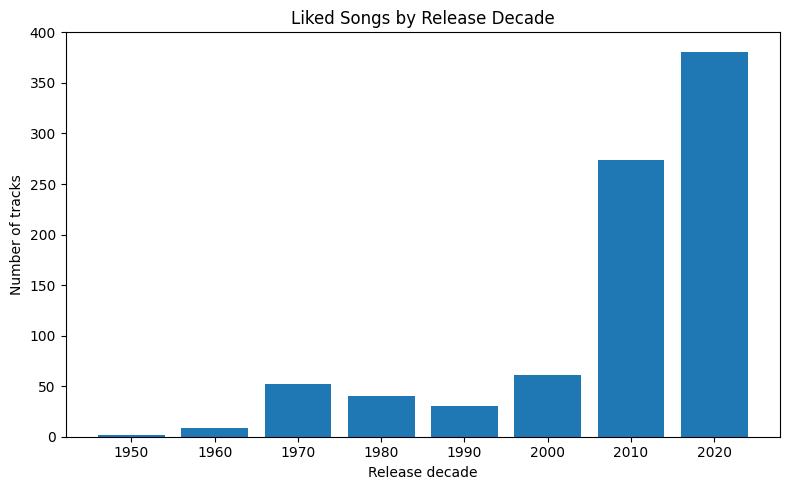

In [14]:
# Bar chart: Number of tracks per release decade
if not decade_counts.empty:
    plt.figure(figsize=(8, 5))
    plt.bar(decade_counts.index.astype(str), decade_counts.values)
    plt.xlabel("Release decade")
    plt.ylabel("Number of tracks")
    plt.title("Liked Songs by Release Decade")
    plt.tight_layout()
    plt.show()
else:
    print("No decade data available (check release_year).")


## Relationships between musical features

So far, I have looked at each feature separately (distributions) and over time (year-by-year trends).  
The next set of plots focuses on how different musical features relate to each other for the tracks in my Liked Songs.

### Energy vs valence (mood vs intensity)

This scatterplot compares **energy** and **valence** for every track.  
Points toward the top-right represent songs that are both energetic and emotionally bright, while points toward the bottom-left represent lower-energy, darker tracks.  
The shape of this cloud tells me whether I mostly listen to high-energy happy tracks, low-energy sad tracks, or a broad mix.


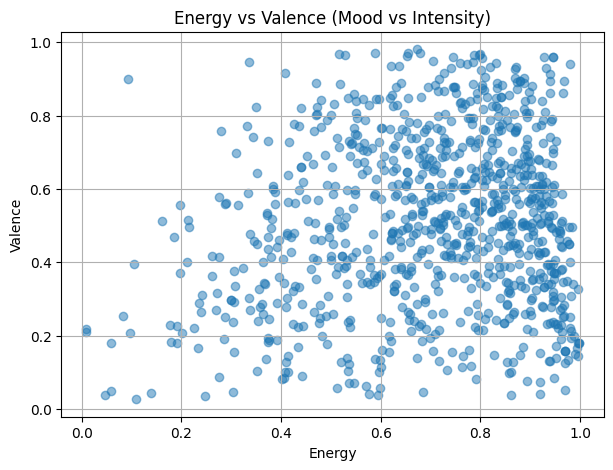

In [15]:
# Scatterplot: Energy vs Valence
if "energy" in data.columns and "valence" in data.columns:
    plt.figure(figsize=(7, 5))
    plt.scatter(data["energy"], data["valence"], alpha=0.5)
    plt.xlabel("Energy")
    plt.ylabel("Valence")
    plt.title("Energy vs Valence (Mood vs Intensity)")
    plt.grid(True)
    plt.show()
else:
    print("Energy or valence column missing.")


### Energy vs tempo

This scatterplot compares **tempo (BPM)** and **energy**.  

If faster songs are usually more intense in my library, the points will slant upward; if I like high-energy songs at all tempos, the cloud will look more spread out.  

This helps distinguish “fast because it’s energetic” from “fast but still relatively relaxed.”

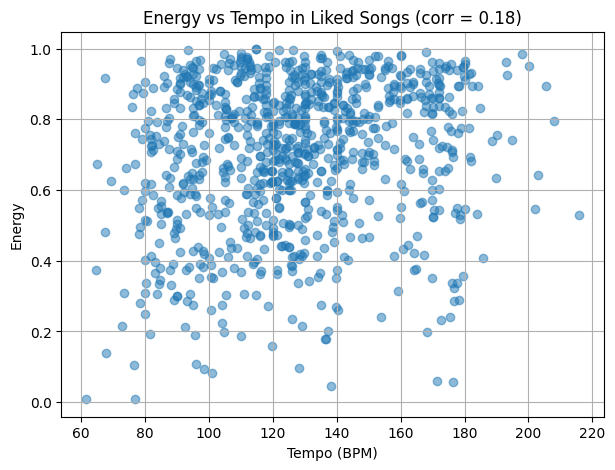

In [16]:
# Scatterplot: Energy vs Tempo WITH correlation in the title
if "energy" in data.columns and "tempo" in data.columns:
    subset = data[["tempo", "energy"]].dropna()

    plt.figure(figsize=(7, 5))
    plt.scatter(subset["tempo"], subset["energy"], alpha=0.5)
    plt.xlabel("Tempo (BPM)")
    plt.ylabel("Energy")

    corr_val = energy_tempo_corr(data)
    if not np.isnan(corr_val):
        plt.title(f"Energy vs Tempo in Liked Songs (corr = {corr_val:.2f})")
    else:
        plt.title("Energy vs Tempo in Liked Songs")

    plt.grid(True)
    plt.show()
else:
    print("Energy or tempo column missing.")


### Correlation between audio features

The correlation heatmap summarizes linear relationships among multiple audio features at once; 

For example: danceability, energy, valence, tempo, acousticness, and liveness.  

Strong positive or negative correlations highlight pairs of features that tend to move together in my listening (for example, high energy combined with low acousticness).

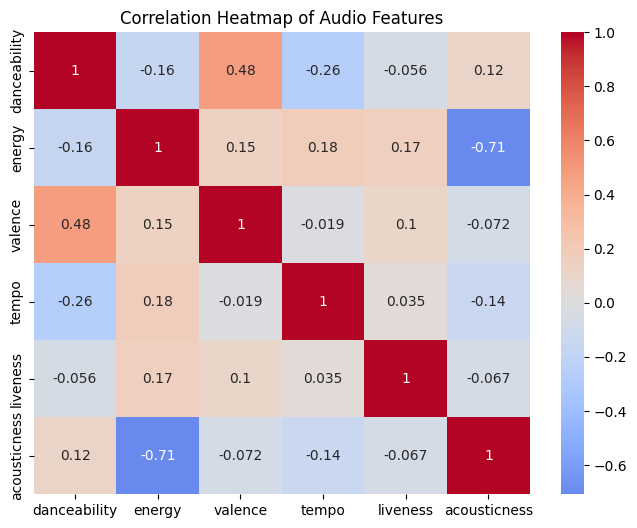

In [17]:
# Correlation heatmap of numeric musical features
import seaborn as sns

features = ["danceability", "energy", "valence", "tempo", "liveness", "acousticness"]
subset = data[features].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(subset.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Audio Features")
plt.show()


## Interpretation and write-up

This section is where I connect the statistical results and plots back to concrete claims about my music taste. Some guiding questions:

### Overall distributions

- **Tempo**: Are most of my liked songs clustered around one tempo range (for example, 120–130 BPM for dance/house), or is there a wide spread? How do the mean, median, and range support that?  

- **Duration**: Do I tend to like shorter tracks (2–3 minutes), longer tracks (5+ minutes), or a mix? Are there many outliers (very long songs, extended mixes, etc.)? 
 
- **Valence**: Is the distribution skewed toward brighter/happier tracks or darker/sadder ones? What does that say about the emotional tone of my library?

### Trends over time

- **Energy by year**: Are there years where my average energy jumps up or down? Can I connect those changes to periods when I was listening to more hype music (e.g., gym playlists, EDM/house phases) versus calmer or more low-key tracks?  

- **Valence by year**: Do certain years show noticeably happier or moodier listening? Does that match what I remember about those years?  

- **Explicit share by year**: Has the proportion of explicit songs increased, decreased, or stayed stable? Does that align with when I got into particular genres or artists?

### Genres

- Which genres dominate the top of the genre bar chart? Do they match how I’d describe my taste to someone else?  
- Are there any genres that are surprisingly common (for example, subgenres I didn’t realize I had so many tracks in)?  
- How do the genre results line up with the numeric features (e.g., high-energy tracks mostly in certain genres)?
